In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR 
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


## Split Training & Testing Data


*   Training data: 2005 - 2018
*   Testing data: 2019 - 2021



|     Model     | factor | Window size | Step size | Horizon |
| :-----------: | :----: | :---------: | :-------: | :-----: |
|  1 day ahead  | close (1c)  |      3      |     1     |    1    |
|               |  all (1a)   |      3      |     1     |    1    |
| 5 days ahead  | close (5c)  |      8      |     1     |    5    |
|               |  all (5a)   |      8      |     1     |    5    |
| 22 days ahead | close (22c)  |     25      |     1     |   22    |
|               |  all (22a)   |     25      |     1     |   22    |

In [16]:
# Read data & split by year
def split_train_test(file_path, start_year, mid_year, final_year):
  full_dataset = pd.read_excel(file_path)
  training_ori = full_dataset[full_dataset['Date - 0'].dt.year.isin(np.arange(start_year, mid_year))]
  testing_ori = full_dataset[full_dataset['Date - 0'].dt.year.isin(np.arange(mid_year, final_year))]
  return training_ori, testing_ori

### Data Select
1.   ONE day ahead


*   close (1c)
*   all factors (1a)



2.   FIVE days ahead


*   close (5c)
*   all factors (5a)



3.   TWENTY-TWO days ahead

*   close (22c)
*   all factors (22a)


In [29]:
def create_train_test_dataset(file_path, file_name, start_year, mid_year, final_year, pred_factor, window_size, horizon):
  training_ori, testing_ori = split_train_test(file_path + file_name, start_year, mid_year, final_year)
  
  # factor = all
  X_train_a = training_ori.iloc[:, 1 + window_size: -1 * (horizon)].values
  X_test_a = testing_ori.iloc[:, 1 + window_size: -1 * (horizon)].values

  # factor = close
  X_train_c = training_ori.loc[:, pred_factor +  ' - ' + str(window_size - 1): pred_factor + ' - 0'].values
  X_test_c = testing_ori.loc[:, pred_factor +  ' - ' + str(window_size - 1): pred_factor + ' - 0'].values

  Y_train = training_ori.iloc[:, -1].values
  Y_test = testing_ori.iloc[:, -1].values
  
  return X_train_a, X_test_a, X_train_c, X_test_c, Y_train, Y_test

In [30]:
file_path = 'Absolute path of DataSource/Amazon'
file_name = ['amazon_3_1.xlsx', 'amazon_8_5.xlsx', 'amazon_25_22.xlsx']
X_train_1a, X_test_1a, X_train_1c, X_test_1c, Y_train_1, Y_test_1 = create_train_test_dataset(file_path, file_name[0], 2010, 2019, 2022, 'Close', 3, 1)
X_train_5a, X_test_5a, X_train_5c, X_test_5c, Y_train_5, Y_test_5 = create_train_test_dataset(file_path, file_name[1], 2010, 2019, 2022, 'Close', 8, 5)
X_train_22a, X_test_22a, X_train_22c, X_test_22c, Y_train_22, Y_test_22 = create_train_test_dataset(file_path, file_name[2], 2010, 2019, 2022, 'Close', 25, 22)

In [31]:
X_train = np.array([X_train_1a, X_train_1c, X_train_5a, X_train_5c, X_train_22a, X_train_22c],dtype=object)
X_test = np.array([X_test_1a, X_test_1c, X_test_5a, X_test_5c, X_test_22a, X_test_22c],dtype=object)
Y_train = np.array([Y_train_1, Y_train_5, Y_train_22],dtype=object)
Y_test = np.array([Y_test_1, Y_test_5, Y_test_22],dtype=object)

In [32]:
Train_dt = []
Test_dt = []
for i in range(6):
  Train_dt.append(np.concatenate((X_train[i],Y_train[i//2].reshape(-1, 1)), axis=1))
  Test_dt.append(np.concatenate((X_test[i],Y_test[i//2].reshape(-1, 1)), axis=1))

In [33]:
Train_dt

[array([[ 136.25    ,  133.429993,  134.600006, ...,  134.690002,
          132.25    ,  132.009995],
        [ 133.429993,  134.600006,  132.009995, ...,  132.25    ,
          130.      ,  130.559998],
        [ 134.600006,  132.009995,  130.559998, ...,  130.      ,
          133.520004,  132.619995],
        ...,
        [1346.      , 1368.890015, 1454.199951, ..., 1470.900024,
         1461.640015, 1473.349976],
        [1368.890015, 1454.199951, 1473.349976, ..., 1461.640015,
         1478.02002 , 1510.800049],
        [1454.199951, 1473.349976, 1510.800049, ..., 1478.02002 ,
         1501.969971, 1465.199951]]),
 array([[ 133.899994,  134.690002,  132.25    ,  132.009995],
        [ 134.690002,  132.25    ,  130.      ,  130.559998],
        [ 132.25    ,  130.      ,  133.520004,  132.619995],
        ...,
        [1343.959961, 1470.900024, 1461.640015, 1473.349976],
        [1470.900024, 1461.640015, 1478.02002 , 1510.800049],
        [1461.640015, 1478.02002 , 1501.969971, 14

## Support Vector Regression & Kernel Ridge Regression 
### Tune parameters by GridSearchCV

SVM


In [34]:
C_svr = np.logspace(2, 5, 4, base = 10)
gamma_svr = np.logspace(-11, -2, 10, base = 10)
parameters_svr = {
    'kernel' : ['rbf'],
    'C': C_svr,
    'gamma': gamma_svr
}
best_param_svr = []
MAPE_svr = []
Y_pred_svr = []

# grid_svr = GridSearchCV(SVR(), parameters_svr, cv = 5, verbose = 1)
grid_svr = SVR(kernel = 'rbf', gamma = 1e-5, C = 1e4)

KRR


In [35]:
alpha_krr = np.logspace(-5, 0, 6)
gamma_krr = np.logspace(-9, -4, 7)
parameters_krr = {
    'kernel' : ['rbf'],
    'alpha': alpha_krr,
    'gamma': gamma_krr
}

best_param_krr = []
MAPE_krr = []
Y_pred_krr = []

# grid_krr = GridSearchCV(KernelRidge(), parameters_krr, cv = 5, verbose = 1)
grid_krr = KernelRidge(kernel='rbf', alpha=1e-05, gamma=0.0001)

Normalization & train & predict

In [36]:
for i in range(6):
  # Normalize
  sc = MinMaxScaler()
  train_sc = sc.fit_transform(Train_dt[i])
  X_train_sc = train_sc[:, :-1]
  Y_train_sc = train_sc[:, -1]

  Y_test_ori = Test_dt[i][:, -1]
  test_sc = sc.transform(Test_dt[i])
  X_test_sc = test_sc[:, :-1]
  Y_test_sc = test_sc[:, -1]

  # support vector regression
  grid_svr.fit(X_train_sc, Y_train_sc)
  Y_pred_svr_sc = grid_svr.predict(X_test_sc)
  test_sc_svr = np.concatenate((X_test_sc,Y_pred_svr_sc.reshape(-1, 1)), axis=1)
  test_inv_svr = sc.inverse_transform(test_sc_svr)
  Y_svr = test_inv_svr[:, -1]
  Y_pred_svr.append(Y_svr)

  # best_param_svr.append(grid_svr.best_estimator_)
  MAPE_svr.append(round(mean_absolute_percentage_error(Y_svr, Y_test_ori), 2))

  # kernel ridge regression
  grid_krr.fit(X_train_sc, Y_train_sc)
  Y_pred_krr_sc = grid_krr.predict(X_test_sc)
  test_sc_krr = np.concatenate((X_test_sc,Y_pred_krr_sc.reshape(-1, 1)), axis=1)
  test_inv_krr = sc.inverse_transform(test_sc_krr)
  Y_krr = test_inv_krr[:, -1]
  Y_pred_krr.append(Y_krr)

  # best_param_krr.append(grid_krr.best_estimator_)
  MAPE_krr.append(round(mean_absolute_percentage_error(Y_krr, Y_test_ori), 2))

In [37]:
print(MAPE_krr, MAPE_svr)

[0.01, 0.01, 0.04, 0.03, 0.14, 0.1] [0.09, 0.11, 0.07, 0.07, 0.1, 0.09]


|     Model     |   factor    |      1 - MAPE |      |      |
| :-----------: | :---------: | :--: | :--: | :--: |
|               |             | KRR  | SVR  |      |
|  1 day ahead  | close  |  99%  | 89%  |      |
|               |  all   |  99%  |  91%  |      |
| 5 days ahead  | close  |  97%  |  93%  |      |
|               |  all   |  96%  |  93%  |      |
| 22 days ahead | close  |  99%  |  91%  |      |
|               |  all   | 86%  | 90%  |      |

### Plot Part

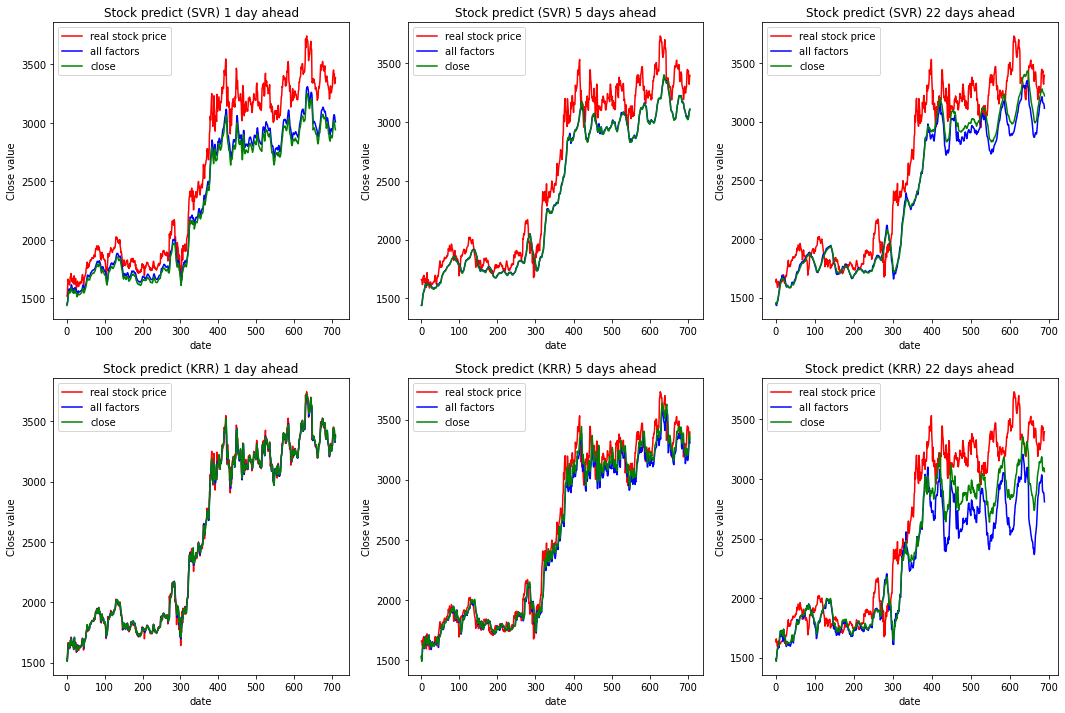

In [41]:
titles = ['1 day ahead', '5 days ahead', '22 days ahead']
sub_plot = [231, 232, 233, 234, 235, 236]
plt.figure(figsize=(18, 12))
for i in range(3):
  size = Y_test[i].shape[0]
  plt.subplot(sub_plot[i])
  plt.plot(range(size), Y_test[i], color = 'red', label='real stock price')
  plt.plot(range(size), Y_pred_svr[2*i], color = 'blue', label='all factors')
  plt.plot(range(size), Y_pred_svr[2*i+1], color = 'green', label='close')
  plt.title('Stock predict (SVR) ' + titles[i])
  plt.xlabel('date')
  plt.ylabel('Close value')
  plt.legend()

  plt.subplot(sub_plot[i + 3])
  plt.plot(range(size), Y_test[i], color = 'red', label='real stock price')
  plt.plot(range(size), Y_pred_krr[2*i], color = 'blue', label='all factors')
  plt.plot(range(size), Y_pred_krr[2*i+1], color = 'green', label='close')
  plt.title('Stock predict (KRR) ' + titles[i])
  plt.xlabel('date')
  plt.ylabel('Close value')
  plt.legend()
plt.show()